<a href="https://colab.research.google.com/github/NaomiInbal/anomaly-detection-and-trajectory-classification/blob/missile_trajectories_for_final_report/LSTM_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM MODELS
This code uploads and runs models of data of missile trajectories in the folder called "missile_data".

To run the models, you must first run the simulator that creates the data.This is the link to the simulator:
https://colab.research.google.com/drive/1ig9DJSc9_JOm16icqWhLN5DHBLDNVAjN#scrollTo=gVCcUOTU-1gr

Alternatively, you can download the existing data from this link: https://drive.google.com/drive/folders/1vsQ1DBiNDY6Ene-2mJa-0BbeGeTBWpT4?usp=drive_link
and put it in Google Drive storage at the location: /content/gdrive/My Drive/

In addition, you will be asked to allow access to Google Drive to upload the data.




In [22]:
import os
import numpy as np
import pandas as pd

# Upload Data

In [23]:
# Mount Google Drive
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [24]:
def upload_data(drive_folder="missile_data"):
    """
    Load dataset from CSV files in a specified folder on Google Drive.

    Parameters:
    - drive_folder (str): Folder name in Google Drive where the dataset is stored.

    Returns:
    - X (numpy.ndarray): Array containing input data from CSV files.
    - Y (numpy.ndarray): Array containing labels from CSV files.
    """
    print("""Starts by upload  missile trajectories from Google Drive...
    This is going to take a while....""")
    # Construct the full path to the dataset folder in Google Drive
    data_dir = f"/content/gdrive/My Drive/{drive_folder}"

    # Check if the folder exists
    if not os.path.exists(data_dir):
        print(f"Folder '{data_dir}' does not exist.")
        print("Upload failed!")
        return None, None

    # List all CSV files in the specified folder
    files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

    # Print the number of CSV files
    print(f"There are {len(files)} CSV files in the '{drive_folder}' folder.")

    # Create empty lists to store data from each CSV file
    X_list = []
    Y_list = []
    required_columns = [
    'Velocity[m/s]', 'Altitude[m]', 'Thrust[N]', 'gravitation [m/s^2]',
    'Temperature[K]', 'Pressure[PSI]', 'Drag[N]', 'Mass[Kg]', 'Density',
    'Label'
    ]


    # Load each CSV file into a separate DataFrame and append it to the lists
    for file in files:
        try:
            df = pd.read_csv(os.path.join(data_dir, file))
        except pd.errors.EmptyDataError:
            print(f"File '{file}' is empty.")

        # Check if the DataFrame has all required columns
        if not all(col in df.columns for col in required_columns):
            print(f"File '{file}' does not include all required columns.")

        num_rows_in_data = 5001 #5000 somples + 1 for the titles
        num_columns_in_data = 10
        # Check if the data upload correctly
        if df.shape != (num_rows_in_data, num_columns_in_data):
            print(f"File '{file}' does not meet the criteria: Found shape {df.shape}, expected {num_rows_in_data, num_columns_in_data}.")
            print("Upload failed!")
            return None, None
        if 'Label' not in df.columns:
            print("Label' not in columns")
            print("Upload failed!")
            return None, None
        X_list.append(df.drop(columns=['Label']))
        Y_list.append(df['Label'][0])


    try:
        # Convert the lists of arrays to NumPy arrays
        X = np.array(X_list)
        Y = np.array(Y_list)

        print("Upload finished successfully!")
        return X, Y

    except Exception as e:
        print(f"An error occurred during upload: {e}")
        print("Upload failed!")
        return None, None

# Preparing The Data

In [25]:
# This function normalize the data using min max method
def min_max_normalization(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized_data = ((data - min_val) / ((max_val - min_val) + 1e-7))
    return normalized_data


def encoder(x, y):
    """
    This function splits the data into training set and validation set.

    Parameters:
    - x: Features
    - y: Labels

    Returns:
    - X_train: Training set features
    - X_test: Validation set features
    - y_train: Training set labels
    - y_test: Validation set labels
    """
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                        random_state=42, stratify=y, shuffle=True)
    return X_train, X_test, y_train, y_test

# Auxiliary functions for LSTM models

In [26]:
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.src.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
import ast
import tensorflow as tf
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import csv
import time
import random
import math
import seaborn as sns
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [27]:
def callbacks_function(name):
    """
    Generate and return a set of Keras callbacks commonly used in training neural networks.

    Parameters:
    - name (str): Name of the ModelCheckpoint file to save the best model weights.

    Returns:
    - tf.keras.callbacks.LearningRateScheduler: Learning rate scheduler that decreases the learning rate
      by half every 5 epochs.
    - tf.keras.callbacks.EarlyStopping: Callback to stop training when a monitored metric has stopped improving.
    - tf.keras.callbacks.ModelCheckpoint: Callback to save the model weights during training.
    """
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='min',
                                                  restore_best_weights=True)
    monitor = tf.keras.callbacks.ModelCheckpoint(name, monitor='val_loss', verbose=0, save_best_only=False
                                                 , save_weights_only=False, mode='min')

    # This functuon decrease the value of learning rate
    def scheduler(epoch, lr):
        if epoch % 5 == 0 and epoch > 0:
            lr = lr / 2
        return lr

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

    return lr_schedule

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
    return early_stop, monitor, lr_schedule


# This function calculates the f1 values
def f1(y_true, y_pred):
    """
    Calculate the F1 score between binary true and predicted labels.

    Parameters:
    - y_true (tf.Tensor): True binary labels.
    - y_pred (tf.Tensor): Predicted binary labels.

    Returns:
    - tf.Tensor: F1 score.

    - F1 score is the harmonic mean of precision and recall.
    - Precision and recall are calculated based on true positives, predicted positives, and possible positives.
    - The parameter 'b' controls the weight of precision in the F1 score calculation.
      """
    # This function calculates the recall
    def recall(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    # This function calculates the precision
    def precision(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    b = 0.5
    return ((((1 + b) ** 2) * (precision * recall)) / (((b ** 2) * (precision)) + recall + tf.keras.backend.epsilon()))


# This function uses to compile the models
def model_comiple_run(num_epochs, initial_learning_rate, model, X_train, Y_train, X_test, y_test, callbacks,
                      optimizer="Adam"):
    """
    Compile and train a neural network model using the specified parameters.

    Parameters:
    - num_epochs (int): Number of training epochs.
    - initial_learning_rate (float): Initial learning rate for the optimizer.
    - model (tf.keras.Model): Neural network model to be compiled and trained.
    - X_train (tf.Tensor): Training input data.
    - Y_train (tf.Tensor): Training target data.
    - X_test (tf.Tensor): Testing input data.
    - y_test (tf.Tensor): Testing target data.
    - callbacks (tuple): Tuple of Keras callbacks to be used during training.
    - optimizer (str): String specifying the optimizer to be used (default is "Adam").

    Returns:
    - tf.keras.callbacks.History: Object containing training metrics and loss history.
    """
    opt = Adam(learning_rate=initial_learning_rate)
    if (optimizer == "Adagrade"):
        opt = Adagrad(learning_rate=initial_learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1])
    model_history = model.fit(X_train, Y_train, validation_data=(X_test, y_test), verbose=1, epochs=num_epochs)
    # batch_size=32, validation_data=(X_test,y_test)\,callbacks=callbacks,verbose=1)
    return model_history


In [28]:

def model_plot(model_history, type=None, plot_all=True):
    """
    Plot training metrics and loss from a model's training history.

    Parameters:
    - model_history (tf.keras.callbacks.History): Training history obtained from model training.
    - type (str): Type of plot to display ('accuracy', 'loss', 'f1'). Default is None.
    - plot_all (bool): If True, plots all available metrics and losses. If False, only plots the specified type.
    """
    plt.plot()
    if plot_all:
        plt.plot(model_history.history['accuracy'], label="Train accuracy")
        plt.plot(model_history.history['val_accuracy'], label="Val accuracy")
        plt.xlabel("Epoch (iteration)")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.legend()
        plt.show()
        plt.plot(model_history.history['loss'], label="Train loss")
        plt.plot(model_history.history['val_loss'], label="Val loss")
        plt.xlabel("Epoch (iteration)")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.show()
        plt.plot(model_history.history['f1'], label="Train f1")
        plt.plot(model_history.history['val_f1'], label="Val f1")
        plt.xlabel("Epoch (iteration)")
        plt.ylabel("F1")
        plt.grid()
        plt.legend()
        plt.show()
    else:
        if type == 'accuracy':
            plt.plot(model_history.history['accuracy'], label="Train accuracy")
            plt.plot(model_history.history['val_accuracy'], label="val_accuracy")
        if type == 'loss':
            plt.plot(model_history.history['loss'], label="Train loss")
            plt.plot(model_history.history['val_loss'], label="val_loss")
        if type == 'f1':
            # Correct the keys for F1 score
            plt.plot(model_history.history['f1'], label="Train f1")
            plt.plot(model_history.history['val_f1'], label="val_f1")
        plt.legend()
        plt.show()


def plot_confusion_matrix(cf_matrix):
    """
    Plot a confusion matrix using a heatmap.

    Parameters:
    - cf_matrix (numpy.ndarray): Confusion matrix to be plotted.

    - The function uses Seaborn and Matplotlib for plotting the confusion matrix heatmap.
    - The confusion matrix is a 2x2 numpy array.
    """
    print('Confusion Matrix')
    ax = plt.subplot()
    sns.heatmap(cf_matrix, annot=True, ax=ax, fmt='d', cmap='Blues', cbar=False)
    # labels, title and ticks
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.xaxis.set_ticklabels(['Not accident', 'Accident'])
    ax.yaxis.set_ticklabels(['Not accident', 'Accident'])
    plt.show()  # Display the plot


# Initial improvements to LSTM models
These are initial attempts at running LSTM models. These are attempts that are not documented in the final report of the project, but they helped us understand and later write more advanced models with more suitable parameters. The more advanced models are detailed in the final report and appear here below under the heading: "LSTM Models"

In [29]:
# LSTM - model 01 : hidden_layers = 1, total_nodes = 40, initial_learning_rate = 0.1, num_epochs = 100 ,optimizer='adam'
def lstm_model01(X_train, X_test, y_train, y_test):
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    # The sigmoid activation function is commonly used for binary classification problems, where the output values
    # range between 0 and 1
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model01'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.1
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule])
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)

    y_pred = model.predict(X_test)
    # Define a threshold for binary classification (e.g., 0.5)
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision
    precision = precision_score(y_test, y_pred_binary)
    # Calculate recall
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


# LSTM - model 02 : hidden_layers = 1, initial_learning_rate = 0.001, optimizer='adam', num_epochs = 100
# Improvement : DataBase - the small DB ,total_nodes = 128
def lstm_model02(X_train, X_test, y_train, y_test):
    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model02'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.001
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule])
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.5  # Define a threshold for binary classification (e.g., 0.5)
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


# LSTM - model 03:  total_nodes = 128, initial_learning_rate = 0.001, num_epochs = 100, , optimizer='adam'
# Improvement : hidden_layers = 2 (Adding one more lstm layer), DataBase - the big DB
def lstm_model03(X_train, X_test, y_train, y_test):
    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model03'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.001
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule])
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)

    y_pred = model.predict(X_test)
    threshold = 0.5  # Define a threshold for binary classification (e.g., 0.5)
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


# LSTM - model 04: hidden_layers = 2, total_nodes = 128, initial_learning_rate = 0.001, num_epochs = 100
# Improvement : optimizer='Adagrade'
def lstm_model04(X_train, X_test, y_train, y_test):
    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model04'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.001
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule], optimizer="Adagrade")
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.5  # Define a threshold for binary classification (e.g., 0.5)
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


# LSTM - model 05: hidden_layers = 2, total_nodes = 128, initial_learning_rate = 0.001, num_epochs = 100, optimizer='adam'
# Improvement : threshold = 0.3
def lstm_model05(X_train, X_test, y_train, y_test):
    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence of param1 inputs with param2 feature each.
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model05'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.001
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule])
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.3  # Define a threshold for binary classification (e.g., 0.5)
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

# LSTM - model 06: hidden_layers = 2, num_epochs = 100
# Improvement : optimizer='Adagrade', initial_learning_rate = 0.01, total_nodes = 16
def lstm_model06(X_train, X_test, y_train, y_test):
    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model06'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.01
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule], optimizer="Adagrade")
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

# LSTM - model 07 : hidden_layers = 1, initial_learning_rate = 0.1, num_epochs = 100, ,optimizer='adam'
# Improvement : total_nodes = 1
def lstm_model07(X_train, X_test, y_train, y_test):
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(1, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # The sigmoid activation function is commonly used for binary classification problems, where the output values
    # range between 0 and 1
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model07'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.1
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule])
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)

    y_pred = model.predict(X_test)
    # Define a threshold for binary classification (e.g., 0.5)
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision
    precision = precision_score(y_test, y_pred_binary)
    # Calculate recall
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

# LSTM - model 08 : hidden_layers = 1, initial_learning_rate = 0.1, num_epochs = 100, ,optimizer='adam'
# Improvement : total_nodes = 16
def lstm_model08(X_train, X_test, y_train, y_test):
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # The sigmoid activation function is commonly used for binary classification problems, where the output values
    # range between 0 and 1
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model08'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.1
    num_epochs = 100
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule])
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)

    y_pred = model.predict(X_test)
    # Define a threshold for binary classification (e.g., 0.5)
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision
    precision = precision_score(y_test, y_pred_binary)
    # Calculate recall
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

# LSTM - model 09: hidden_layers = 2, total_nodes = 16, optimizer='Adagrade', initial_learning_rate = 0.01, num_epochs = 50
# Improvement : adding dropout
def lstm_model09(X_train, X_test, y_train, y_test):
    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model09'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.01
    num_epochs = 50
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule], optimizer="Adagrade")
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


# LSTM - model 010 : hidden_layers = 1, total_nodes = 15, initial_learning_rate = 0.001 ,optimizer='adam'
# Improvement : initial_learning_rate = 0.001, num_epochs = 20,  threshold = 0.3
def lstm_model010(X_train, X_test, y_train, y_test):
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(15, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # The sigmoid activation function is commonly used for binary classification problems, where the output values
    # range between 0 and 1
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model010'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.001
    num_epochs = 50
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule])
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.3  # Define a threshold for binary classification (e.g., 0.5)
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision
    precision = precision_score(y_test, y_pred_binary)
    # Calculate recall
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


# LSTM Models

In [30]:
def lstm_model_with_1_hidden_layer(X_train, X_test, y_train, y_test, model_name, total_nodes=16, initial_learning_rate=0.001, num_epochs=100, opt='adam', threshold=0.5):

    """
    Build, train, and evaluate an LSTM model with one hidden layer for binary classification.

    Parameters:
    - X_train (numpy.ndarray): Training input data with shape (samples, time steps, features).
    - X_test (numpy.ndarray): Testing input data with shape (samples, time steps, features).
    - y_train (numpy.ndarray): Training target data with binary labels.
    - y_test (numpy.ndarray): Testing target data with binary labels.
    - model_name (str): Name of the model used for saving checkpoints.
    - total_nodes (int): Number of LSTM units in the hidden layer. Default is 16.
    - initial_learning_rate (float): Initial learning rate for the optimizer. Default is 0.001.
    - num_epochs (int): Number of training epochs. Default is 100.
    - opt (str): String specifying the optimizer to be used. Default is 'adam'.
    - threshold (float): Threshold for binary classification. Default is 0.5.

    - The function constructs an LSTM model with one hidden layer, followed by a Dense layer with a sigmoid activation.
    - It compiles and trains the model using the specified parameters and displays training history plots.
    - Evaluates the model on the testing data and prints the final loss.
    - Generates and displays a confusion matrix along with precision and recall scores.
    """

    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(total_nodes, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    # The sigmoid activation function is commonly used for binary classification problems-
    # where the output values range between 0 and 1
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    lr_schedule = callbacks_function(model_name)
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule], optimizer = opt)
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision
    precision = precision_score(y_test, y_pred_binary)
    # Calculate recall
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

In [31]:
def lstm_model_with_Batch_Normalization(X_train, X_test, y_train, y_test,model_name):

    """
    Build, train, and evaluate an LSTM model with Batch Normalization for binary classification.

    Parameters:
    - X_train (numpy.ndarray): Training input data with shape (samples, time steps, features).
    - X_test (numpy.ndarray): Testing input data with shape (samples, time steps, features).
    - y_train (numpy.ndarray): Training target data with binary labels.
    - y_test (numpy.ndarray): Testing target data with binary labels.
    - model_name (str): Name of the model used for saving checkpoints.


    - Constructs an LSTM model with Batch Normalization layers, enhancing training stability and convergence.
    - Batch Normalization normalizes the input of each layer, reducing internal covariate shift during training.
    - The model includes LSTM layers, Batch Normalization after each LSTM layer, a Flatten layer, and a Dense layer.
    - Compiles and trains the model using specified parameters, and displays training history plots.
    - Evaluates the model on testing data, printing the final loss, and generates a confusion matrix.
    - Computes precision and recall scores based on the binary classification results.
    """

    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'Model2'
    lr_schedule = callbacks_function(model_name)
    initial_learning_rate = 0.01
    num_epochs = 50
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule], optimizer="Adagrade")
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

In [32]:
def lstm_model_with_2_hidden_layer(X_train, X_test, y_train, y_test, model_name, total_nodes = 16,initial_learning_rate = 0.001, num_epochs = 100, opt='adam', threshold = 0.5):

    """
    Build, train, and evaluate an LSTM model with two hidden layer for binary classification.

    Parameters:
    - X_train (numpy.ndarray): Training input data with shape (samples, time steps, features).
    - X_test (numpy.ndarray): Testing input data with shape (samples, time steps, features).
    - y_train (numpy.ndarray): Training target data with binary labels.
    - y_test (numpy.ndarray): Testing target data with binary labels.
    - model_name (str): Name of the model used for saving checkpoints.
    - total_nodes (int): Number of LSTM units in the hidden layer. Default is 16.
    - initial_learning_rate (float): Initial learning rate for the optimizer. Default is 0.001.
    - num_epochs (int): Number of training epochs. Default is 100.
    - opt (str): String specifying the optimizer to be used. Default is 'adam'.
    - threshold (float): Threshold for binary classification. Default is 0.5.

    - The function constructs an LSTM model with two hidden layer, followed by a Dense layer with a sigmoid activation.
    - It compiles and trains the model using the specified parameters and displays training history plots.
    - Evaluates the model on the testing data and prints the final loss.
    - Generates and displays a confusion matrix along with precision and recall scores.
    """

    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(total_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(total_nodes, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    lr_schedule = callbacks_function(model_name)
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule], optimizer = opt)
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

In [33]:
def lstm_model_with_3_hidden_layer(X_train, X_test, y_train, y_test, model_name, total_nodes = 16, initial_learning_rate = 0.01, opt='Adagrade', num_epochs = 50):

    """
    Build, train, and evaluate an LSTM model with three hidden layer for binary classification.

    Parameters:
    - X_train (numpy.ndarray): Training input data with shape (samples, time steps, features).
    - X_test (numpy.ndarray): Testing input data with shape (samples, time steps, features).
    - y_train (numpy.ndarray): Training target data with binary labels.
    - y_test (numpy.ndarray): Testing target data with binary labels.
    - model_name (str): Name of the model used for saving checkpoints.
    - total_nodes (int): Number of LSTM units in the hidden layer. Default is 16.
    - initial_learning_rate (float): Initial learning rate for the optimizer. Default is 0.001.
    - num_epochs (int): Number of training epochs. Default is 100.
    - opt (str): String specifying the optimizer to be used. Default is 'adam'.
    - threshold (float): Threshold for binary classification. Default is 0.5.

    - The function constructs an LSTM model with three hidden layer, followed by a Dense layer with a sigmoid activation.
    - It compiles and trains the model using the specified parameters and displays training history plots.
    - Evaluates the model on the testing data and prints the final loss.
    - Generates and displays a confusion matrix along with precision and recall scores.
    """

    tf.keras.backend.clear_session()
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence
    # of param1 inputs with param2 feature each.
    model.add(LSTM(total_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(total_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(total_nodes, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    lr_schedule = callbacks_function(model_name)
    model_history = model_comiple_run(num_epochs, initial_learning_rate, model, X_train, y_train, X_test, y_test,
                                      callbacks=[lr_schedule], optimizer=opt)
    model_plot(model_history)
    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0])  # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)
    y_pred = model.predict(X_test)
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)  # Convert predicted probabilities to binary labels
    cf_matrix = confusion_matrix(y_test, y_pred_binary)
    plot_confusion_matrix(cf_matrix)
    # Calculate precision & recall
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


###A call to the upload data function and the prepare data function

In [34]:
    X,Y = upload_data()
    X_normalized = min_max_normalization(X)
    X_train, X_test, y_train, y_test = encoder(X_normalized, Y)

Starts by upload  missile trajectories from Google Drive...
    This is going to take a while....
There are 2600 CSV files in the 'missile_data' folder.
Upload finished successfully!


###Initial improvements to LSTM models


In [35]:
    # lstm_model01(X_train, X_test, y_train, y_test)
    # lstm_model02(X_train, X_test, y_train, y_test)
    # lstm_model03(X_train, X_test, y_train, y_test)
    # lstm_model04(X_train, X_test, y_train, y_test)
    # lstm_model05(X_train, X_test, y_train, y_test)
    # lstm_model06(X_train, X_test, y_train, y_test)
    # lstm_model07(X_train, X_test, y_train, y_test)
    # lstm_model08(X_train, X_test, y_train, y_test)
    # lstm_model09(X_train, X_test, y_train, y_test)
    # lstm_model010(X_train, X_test, y_train, y_test)


#The final LSTM models


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16)                1664      
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1681 (6.57 KB)
Trainable params: 1681 (6.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
65/65 [==============================] - 12s 154ms/step - loss: 0.4899 - accuracy: 0.7812 - f1: 0.1482 - val_loss: 0.3306 - val_accuracy: 0.9365 - val_f1: 1.6052
Epoch 2/100
65/65 [==============================] - 10s 148ms/step - loss: 0.2782 - accuracy: 0.9212 - f1: 1.49

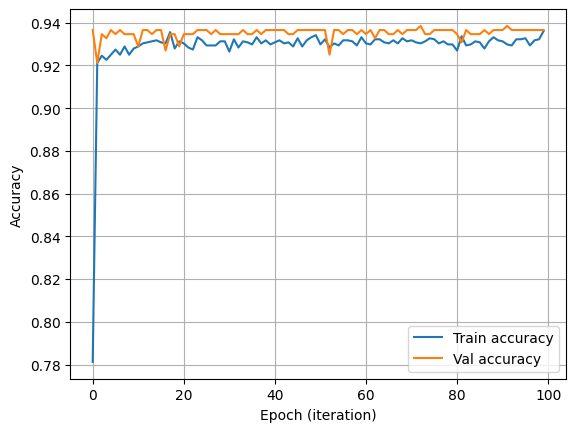

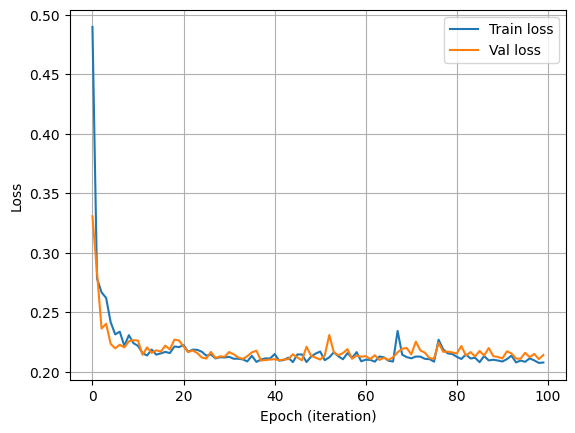

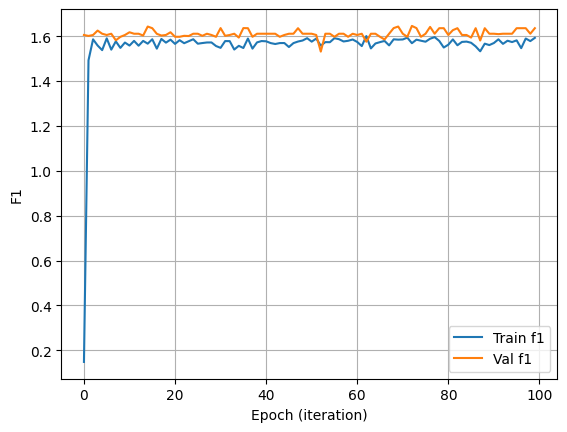

520/520 [==============================] - 32s 61ms/step - loss: 0.2139 - accuracy: 0.9365 - f1: 0.3185
Final loss 1 (cross-entropy and accuracy and F1): [0.21391120553016663, 0.9365384578704834, 0.3184618055820465]
17/17 [==============================] - 1s 61ms/step
Confusion Matrix


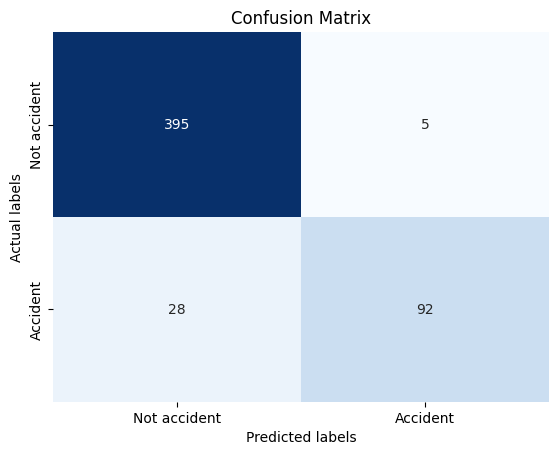

Precision: 0.9484536082474226
Recall: 0.7666666666666667


In [36]:
    lstm_1 = lstm_model_with_1_hidden_layer(X_train, X_test, y_train, y_test, "Model_1", total_nodes = 16, initial_learning_rate = 0.001, num_epochs = 100 ,opt='adam')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5001, 16)          1664      
                                                                 
 batch_normalization (Batch  (None, 5001, 16)          64        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

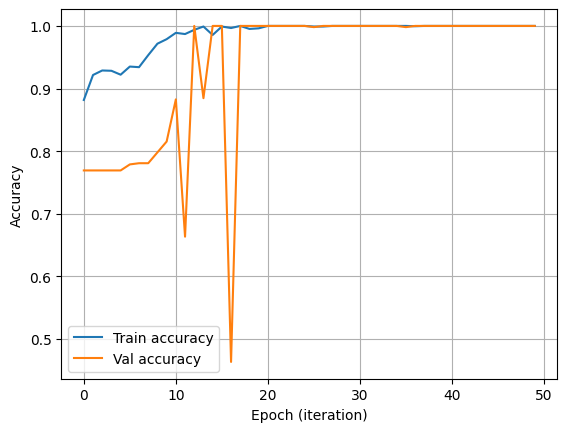

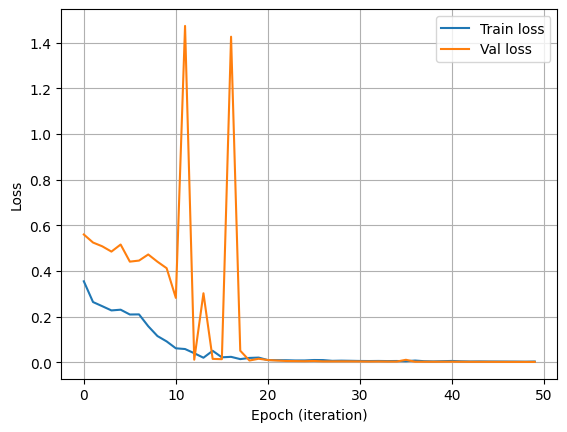

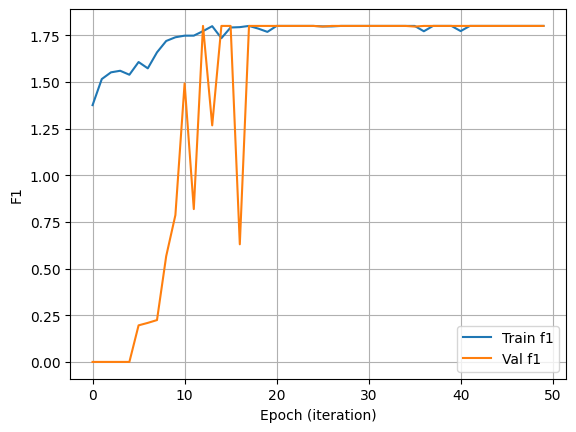

520/520 [==============================] - 60s 114ms/step - loss: 0.0020 - accuracy: 1.0000 - f1: 0.4154
Final loss 1 (cross-entropy and accuracy and F1): [0.0020187953487038612, 1.0, 0.41538506746292114]
17/17 [==============================] - 3s 107ms/step
Confusion Matrix


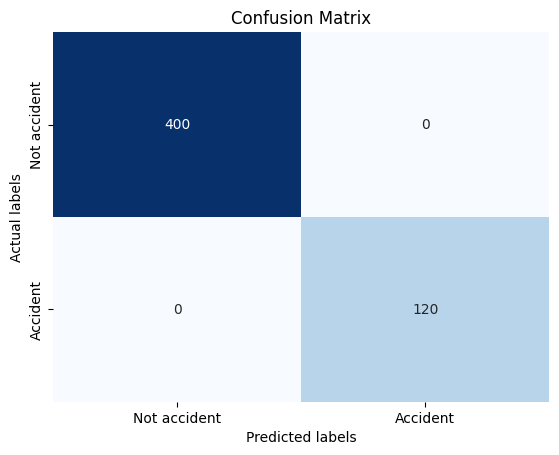

Precision: 1.0
Recall: 1.0


In [37]:
    lstm_2 = lstm_model_with_Batch_Normalization(X_train, X_test, y_train, y_test, "Model_2")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5001, 128)         70656     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 202369 (790.50 KB)
Trainable params: 202369 (790.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
65/65 [==============================] - 24s 321ms/step - loss: 0.5460 - accuracy: 0.7697 - f1: 0.0168 - val_loss: 0.4844 - val_accuracy

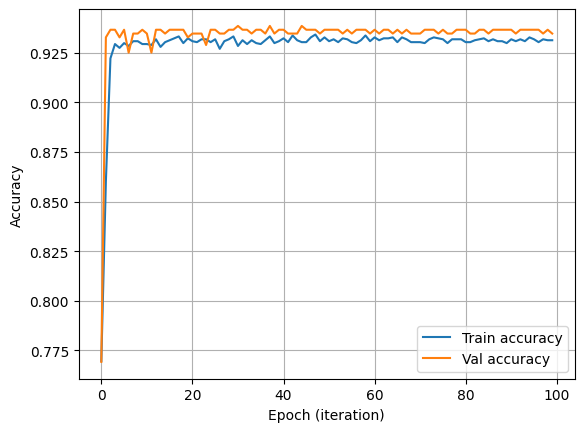

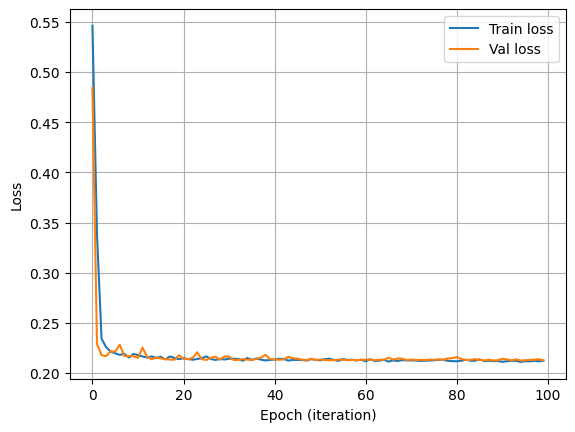

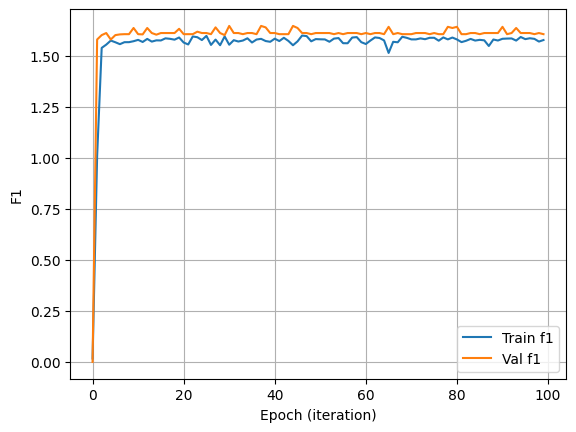

520/520 [==============================] - 62s 118ms/step - loss: 0.2126 - accuracy: 0.9346 - f1: 0.3185
Final loss 1 (cross-entropy and accuracy and F1): [0.21255062520503998, 0.9346153736114502, 0.3184618055820465]
17/17 [==============================] - 3s 114ms/step
Confusion Matrix


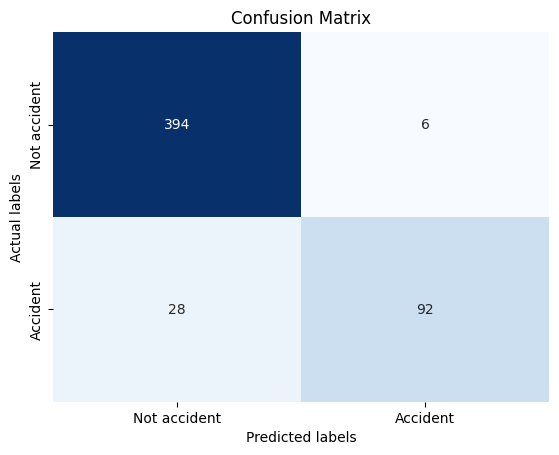

Precision: 0.9387755102040817
Recall: 0.7666666666666667


In [38]:
    lstm_3 = lstm_model_with_2_hidden_layer(X_train, X_test, y_train, y_test, "Model_3", total_nodes = 128,initial_learning_rate = 0.01, num_epochs = 100, opt='Adagrade')


In [ ]:
    lstm_4 = lstm_model_with_1_hidden_layer(X_train, X_test, y_train, y_test, "Model_4", total_nodes = 32, initial_learning_rate = 0.001, num_epochs = 50 ,opt='adam')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5376      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5409 (21.13 KB)
Trainable params: 5409 (21.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
65/65 [==============================] - 13s 170ms/step - loss: 0.4242 - accuracy: 0.8019 - f1: 0.6771 - val_loss: 0.3324 - val_accuracy: 0.9135 - val_f1: 1.5939
Epoch 2/50
65/65 [==============================] - 10s 161ms/step - loss: 0.2846 - accuracy: 0.9221 - f1: 1.55

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16)                1664      
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1681 (6.57 KB)
Trainable params: 1681 (6.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
65/65 [==============================] - 12s 162ms/step - loss: 0.5534 - accuracy: 0.7500 - f1: 0.1307 - val_loss: 0.4692 - val_accuracy: 0.7692 - val_f1: 0.0000e+00
Epoch 2/50
65/65 [==============================] - 10s 147ms/step - loss: 0.3549 - accuracy: 0.8553 - f1: 1.

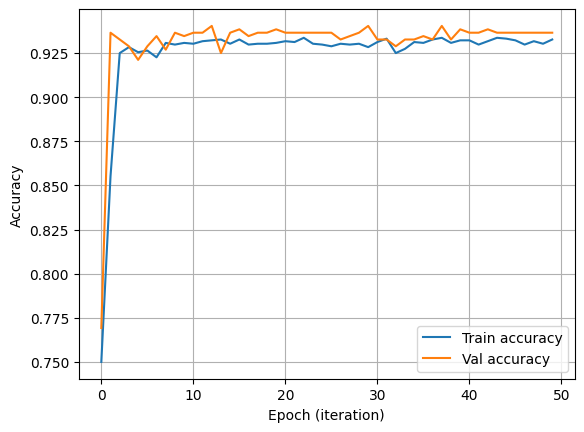

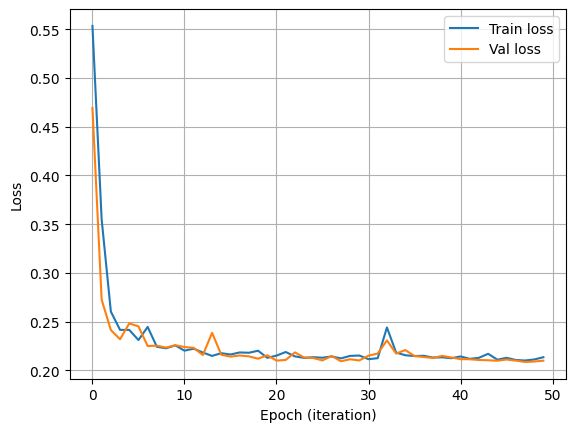

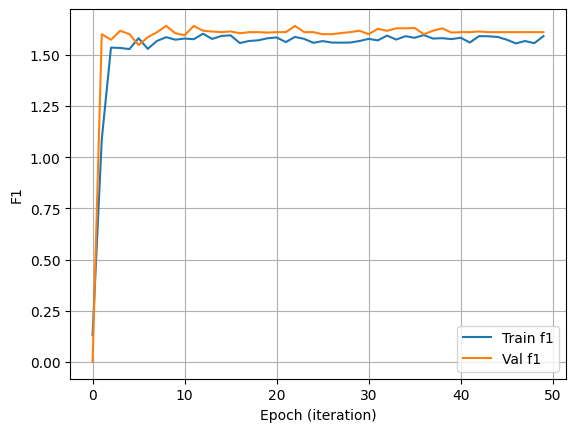

520/520 [==============================] - 34s 66ms/step - loss: 0.2099 - accuracy: 0.9365 - f1: 0.3219
Final loss 1 (cross-entropy and accuracy and F1): [0.20989999175071716, 0.9365384578704834, 0.3219233453273773]
17/17 [==============================] - 1s 61ms/step
Confusion Matrix


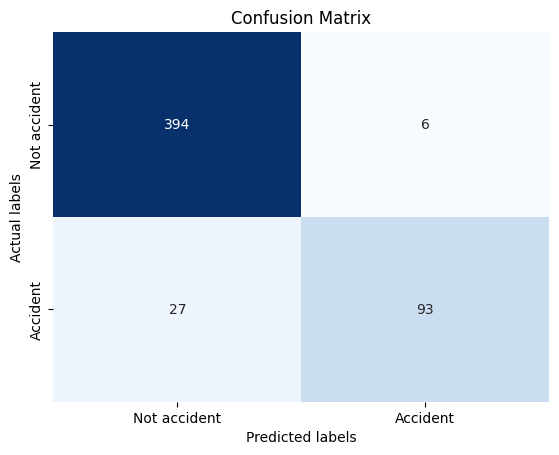

Precision: 0.9393939393939394
Recall: 0.775


In [40]:
    lstm_5 = lstm_model_with_1_hidden_layer(X_train, X_test, y_train, y_test, "Model_5", total_nodes = 16, initial_learning_rate = 0.001, num_epochs = 50 ,opt='adam')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5001, 16)          1664      
                                                                 
 lstm_1 (LSTM)               (None, 5001, 16)          2112      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 5905 (23.07 KB)
Trainable params: 5905 (23.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
65/65 [====

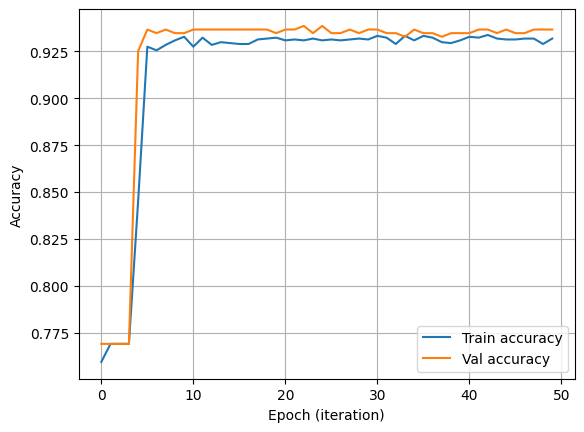

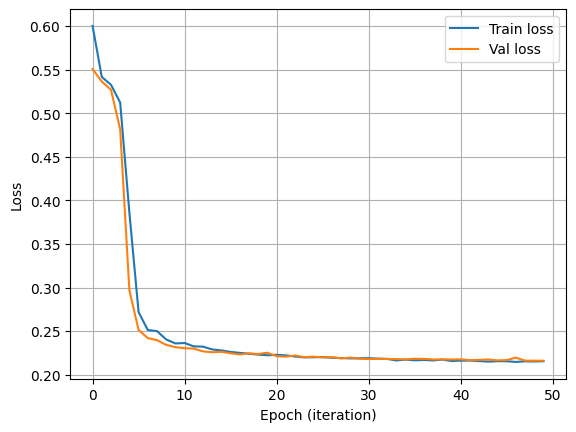

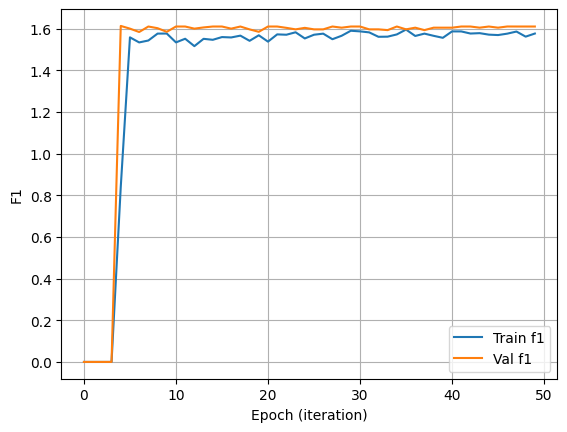

520/520 [==============================] - 85s 164ms/step - loss: 0.2160 - accuracy: 0.9365 - f1: 0.3219
Final loss 1 (cross-entropy and accuracy and F1): [0.21599602699279785, 0.9365384578704834, 0.3219233453273773]
17/17 [==============================] - 3s 153ms/step
Confusion Matrix


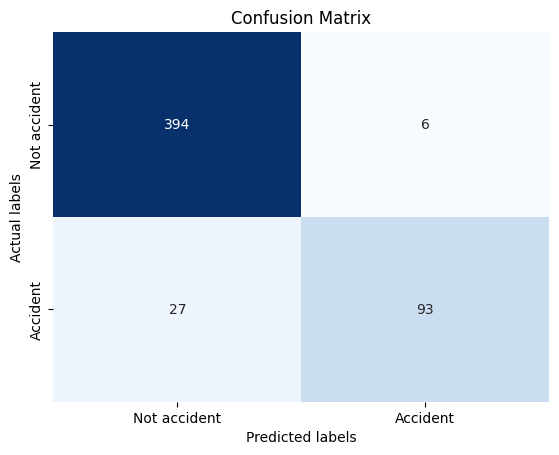

Precision: 0.9393939393939394
Recall: 0.775


In [41]:
    lstm_6 = lstm_model_with_3_hidden_layer(X_train, X_test, y_train, y_test, "Model_6", total_nodes = 16, initial_learning_rate = 0.01, num_epochs = 50 ,opt='Adagrade')
